In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm, M63

In [17]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

dt = 0.01

def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

In [18]:
nature = X_nature[:,:16]
obs = np.sqrt(2) * np.random.randn(*nature.shape) + nature
obs_tmp = obs.copy()
obs_tmp[:,3::8] = 0
obs -= obs_tmp
obs

array([[ 0.        ,  0.        ,  0.        , -1.97406929,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -3.19655482,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.24065875,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.00629413,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 20.27969182,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 18.82268161,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [19]:
def _find_window_range(towindow_len, window_len, forecast_len, window_num):
    """
    return example: [(0, 3, 6), (10, 13, 16), ...]
    -> First assimilation: initial time at 0'th timestamp, assimilation window start at 3'rd 
    timestamp, and assimilation window end at 6'th timestamp.
    -> Second assimilation: initial time at 10'th timestamp, assimilation window start at 13'rd
    timestamp, and assimilation window end at 16'th timestamp.
    """
    tol_len = towindow_len + window_len + forecast_len
    win_range = []
    for iwin in range(window_num):
        ini_time = tol_len * iwin
        win_start = ini_time + towindow_len
        win_end = win_start + window_len - 1
        locations = (ini_time, win_start, win_end)
        win_range.append(locations)
        
    return win_range

win_range = _find_window_range(3, 1, 4, 2)
win_range

[(0, 3, 3), (8, 11, 11)]

In [21]:
obserr = np.random.multivariate_normal([0, 0, 0], R, size=nature.shape[1]).T
obs = nature + obserr
obs_tmp = obs.copy()
obs_tmp[:,3::8] = 0
obs -= obs_tmp

towindow_len = 3
window_num = 200
window_len = 1
forecast_len = 4
H_func= lambda arr: arr
H = np.eye(3)
M = lambda x: M63(x, dt)

In [23]:
analysis = np.zeros_like(obs)

In [25]:
def _gradient_4dvar_costfunction(x, xb, xtrac, yo, Pb, R, M, H_func=None, H=None):
    """
    x, xb: (ndim, 1)
    xtrac: (ndim, window)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    H_func: (window,)
    M: (window, ndim, ndim)
    H: (window, N, ndim)
    """
    No, assim_window_len = yo.shape
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        H = np.concatenate([np.eye(No)[np.newaxis] for i in range(assim_window_len)])
    part1 = np.linalg.inv(Pb) @ (x-xb)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Mj = M[j,:,:]
        Hj = H[j,:,:]
        Rj = R[j,:,:]
        H_fj = H_func[j]
        xtracj = xtrac[:,[j]]
        part2 += Mj.T @ Hj.T @ np.linalg.inv(Rj) @ (yj - H_fj(xtracj))
    return part1 - part2

In [53]:
xb = X_ini

for iwin, (ini_time, start_win, end_win) in enumerate(win_range):
    print(iwin)
    
    tol_len = towindow_len + window_len
    ts = np.linspace(0, (tol_len-1)*dt, tol_len)
    x = xb.copy()
    
    if R.ndim == 2:
        R = np.concatenate([R[np.newaxis,:,:] for i in range(window_len)])
        
    o = obs[:,start_win:end_win+1]
    
    ######################### analysis ######
    H_func_list = [H_func for _ in range(window_len)]
    H_list = np.stack([H for _ in range(window_len)])
    
    maxiter = 1000
    for _ in range(maxiter):
        x_forecast = lorenz63_fdm(x.ravel(), ts)
        
        Ms = []
        m = np.eye(3)
        for i in range(towindow_len):
            m = M63(x_forecast[:,i], dt) @ m
            
        for i in range(window_len):
            m = M63(x_forecast[:,i+towindow_len], dt) @ m
            Ms.append(m)
        Ms = np.stack(Ms)
        
        r = 0.01
        gradient = _gradient_4dvar_costfunction(x, xb, x_forecast, o, Pb, R, Ms, H_func_list, H_list)
        x_new = x - r * gradient
        
        epsilon = 0.0001
        if np.linalg.norm(gradient) <= epsilon:
            x = x_new
            break
        else:
            x = x_new
    #########################################
    
    xa_trajectory = lorenz63_fdm(x.ravel(), ts)
    xa = xa_trajectory[:,[-1]]
    analysis[:, ini_time:end_win+1] = xa_trajectory
    
    if iwin != len(win_range) - 1:
        forecast_start = end_win
        forecast_end = win_range[iwin+1][0] - 1
    else:
        forecast_start = end_win
        forecast_end = obs.shape[1] - 1
        
    forecast_len = forecast_end - forecast_start + 1
    ts = np.linspace(0, (forecast_len-1)*dt, forecast_len)
    xa_forecast = lorenz63_fdm(xa.ravel(), ts)
    analysis[:, forecast_start:forecast_end+1] = xa_forecast
    xb = xa_forecast[:,[-1]]

0
[[13.42577381]
 [11.52981358]
 [34.57606458]]
[[ 4.65164964]
 [ 0.96071859]
 [28.87824351]]
1
[[ 2.72816751]
 [ 1.15505495]
 [24.12616137]]
[[ 0.6692204 ]
 [-1.40131093]
 [21.68777131]]


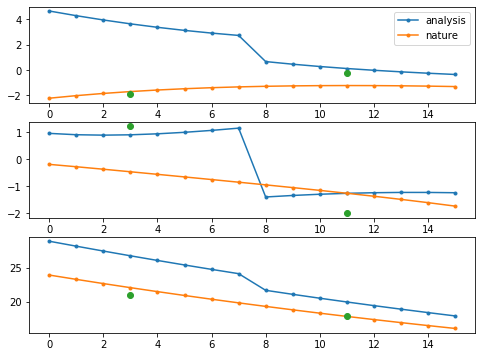

In [54]:
ttt = np.arange(0, nature.shape[1], 1)

fig, axs = plt.subplots(nrows=3, figsize=(8, 6))
for i in range(3):
    axs[i].plot(ttt, analysis[i,:], '.-', label='analysis')
    axs[i].plot(ttt, nature[i,:], '.-', label='nature')
    
    idx = np.all(obs != 0, axis=0)
    axs[i].plot(ttt[idx], obs[i,idx], 'o')
axs[0].legend();